## ECG Image Classification using CNN

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define paths
train_data_dir = '../data/ECG_Image_data/train'
test_data_dir = '../data/ECG_Image_data/test'

# Define parameters
batch_size = 32
img_height = 128
img_width = 128
epochs = 30

Training data:
Classes: ['F', 'M', 'N', 'Q', 'S', 'V']
Sample counts per class:
F: 642
M: 8405
N: 75709
Q: 6431
S: 2223
V: 5789

Test data:
Classes: ['F', 'M', 'N', 'Q', 'S', 'V']
Sample counts per class:
F: 161
M: 2101
N: 18926
Q: 1608
S: 556
V: 1447


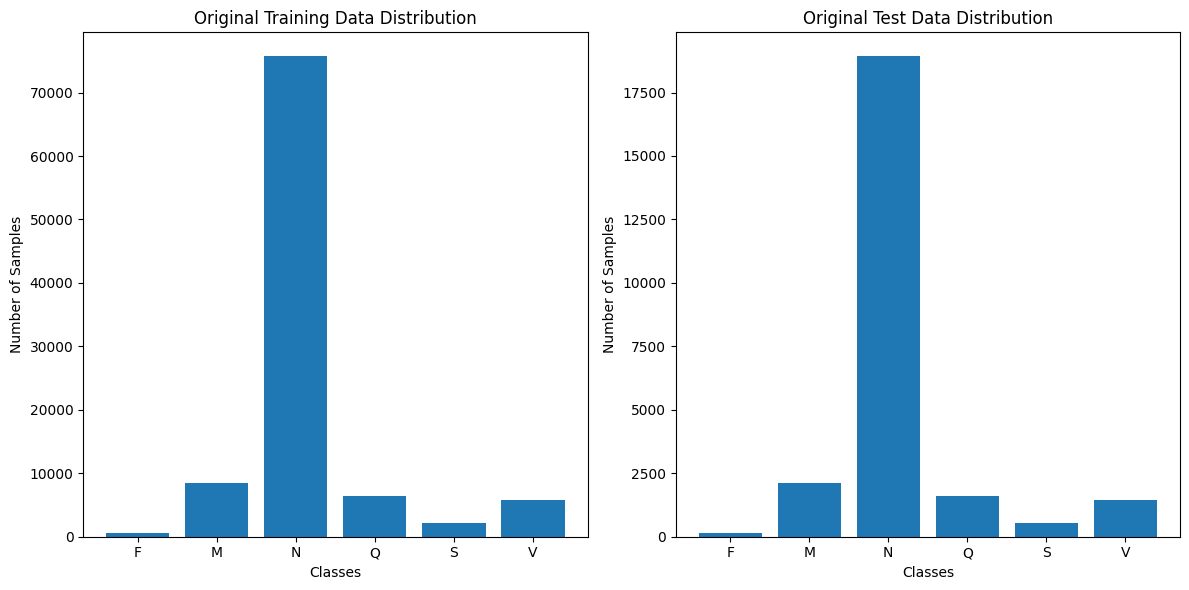

In [8]:
# Function to explore dataset
def explore_data(data_dir):
    """Explore the dataset structure and show sample counts"""
    classes = sorted([d for d in os.listdir(data_dir) 
                    if os.path.isdir(os.path.join(data_dir, d))])
    print(f"Classes: {classes}")
    
    class_counts = {}
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        count = len([name for name in os.listdir(class_dir) 
                    if os.path.isfile(os.path.join(class_dir, name))])
        class_counts[class_name] = count
    
    print("Sample counts per class:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")
    
    return class_counts, classes

# Explore training and test data
print("Training data:")
train_counts, train_classes = explore_data(train_data_dir)
print("\nTest data:")
test_counts, test_classes = explore_data(test_data_dir)

# Visualize class distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(train_counts.keys(), train_counts.values())
plt.title('Original Training Data Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')

plt.subplot(1, 2, 2)
plt.bar(test_counts.keys(), test_counts.values())
plt.title('Original Test Data Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.savefig('../data/original_class_distribution.png')
plt.show()

In [9]:
class BalancedGenerator:
    """A reliable balanced batch generator for ECG classification"""
    def __init__(self, data_dir, batch_size, target_size, classes=None):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.target_size = target_size
        
        # Identify classes
        if classes is None:
            self.classes = sorted([d for d in os.listdir(data_dir) 
                         if os.path.isdir(os.path.join(data_dir, d))])
        else:
            self.classes = classes
            
        self.num_classes = len(self.classes)
        
        # Create consistent class indices mapping
        self.class_indices = {cls: i for i, cls in enumerate(self.classes)}
        self.indices_to_class = {i: cls for i, cls in enumerate(self.classes)}
        
        print(f"Creating generator with {self.num_classes} classes: {self.classes}")
        print(f"Class indices: {self.class_indices}")
        
        # Create ImageDataGenerator with reasonable augmentation
        self.train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            brightness_range=[0.85, 1.15],
            fill_mode='nearest',
            validation_split=0.2
        )
        
        # Simple validation and test generator
        self.val_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2
        )
        
        # Create generators for each class
        self.train_gens = {}
        self.val_gens = {}
        
        # Setup generators for each class
        for class_name in self.classes:
            # Training generator
            class_dir = os.path.join(data_dir, class_name)
            self.train_gens[class_name] = self.train_datagen.flow_from_directory(
                directory=data_dir,
                target_size=target_size,
                color_mode='grayscale',
                classes=[class_name],
                class_mode='binary',  # Use binary since we're isolating each class
                batch_size=batch_size // self.num_classes,
                shuffle=True,
                subset='training'
            )
            
            # Validation generator
            self.val_gens[class_name] = self.val_datagen.flow_from_directory(
                directory=data_dir,
                target_size=target_size,
                color_mode='grayscale',
                classes=[class_name],
                class_mode='binary',
                batch_size=batch_size // self.num_classes,
                shuffle=True,
                subset='validation'
            )
            
            print(f"Created generators for class {class_name}")
    
    def flow(self):
        """Generate balanced batches with correct class indices"""
        while True:
            batch_x = []
            batch_y = []
            
            # Get samples from each class
            for class_name in self.classes:
                # Get a mini-batch for this class
                x, _ = next(self.train_gens[class_name])
                
                # Create one-hot encoding for this class
                y = np.zeros((len(x), self.num_classes))
                y[:, self.class_indices[class_name]] = 1
                
                batch_x.append(x)
                batch_y.append(y)
            
            # Combine samples from all classes
            batch_x = np.vstack(batch_x)
            batch_y = np.vstack(batch_y)
            
            # Shuffle the combined batch
            indices = np.arange(len(batch_x))
            np.random.shuffle(indices)
            
            yield batch_x[indices], batch_y[indices]
    
    def get_validation_data(self):
        """Generate validation data with correct class indices"""
        while True:
            batch_x = []
            batch_y = []
            
            # Get samples from each class
            for class_name in self.classes:
                try:
                    x, _ = next(self.val_gens[class_name])
                except StopIteration:
                    # Reset generator if it's exhausted
                    self.val_gens[class_name].reset()
                    x, _ = next(self.val_gens[class_name])
                
                # Create one-hot encoding for this class
                y = np.zeros((len(x), self.num_classes))
                y[:, self.class_indices[class_name]] = 1
                
                batch_x.append(x)
                batch_y.append(y)
            
            # Combine samples from all classes
            batch_x = np.vstack(batch_x)
            batch_y = np.vstack(batch_y)
            
            # Shuffle the combined batch
            indices = np.arange(len(batch_x))
            np.random.shuffle(indices)
            
            yield batch_x[indices], batch_y[indices]

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Create balanced generator for training
balanced_generator = BalancedGenerator(
    train_data_dir,
    batch_size,
    (img_height, img_width),
    classes=train_classes
)

# Create test generator with matching class indices
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,
    classes=balanced_generator.classes  # Use same class order as training
)

# Verify consistency of class indices
print("\nTraining class indices:", balanced_generator.class_indices)
print("Test class indices:", test_generator.class_indices)

Creating generator with 6 classes: ['F', 'M', 'N', 'Q', 'S', 'V']
Class indices: {'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}
Found 514 images belonging to 1 classes.
Found 128 images belonging to 1 classes.
Created generators for class F
Found 6724 images belonging to 1 classes.
Found 1681 images belonging to 1 classes.
Created generators for class M
Found 60568 images belonging to 1 classes.
Found 15141 images belonging to 1 classes.
Created generators for class N
Found 5145 images belonging to 1 classes.
Found 1286 images belonging to 1 classes.
Created generators for class Q
Found 1779 images belonging to 1 classes.
Found 444 images belonging to 1 classes.
Created generators for class S
Found 4632 images belonging to 1 classes.
Found 1157 images belonging to 1 classes.
Created generators for class V
Found 24799 images belonging to 6 classes.

Training class indices: {'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}
Test class indices: {'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V'

In [10]:
def build_ecg_model(input_shape=(img_height, img_width, 1), num_classes=6):
    """Build a CNN model with appropriate architecture for ECG classification"""
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Flatten and Dense layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile model with appropriate learning rate
    optimizer = Adam(learning_rate=0.0001)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create model with correct number of classes
model = build_ecg_model(num_classes=balanced_generator.num_classes)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,586,886 (17.50 MB)

 Trainable params: 4,585,414 (17.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [11]:
# Define callbacks for better training
checkpoint = ModelCheckpoint(
    '../backend/model/ecg_model_balanced.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # More gradual reduction
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Calculate training steps
# Use a fixed number of steps that ensures all classes are seen multiple times
steps_per_epoch = 100  # This ensures good balance
validation_steps = 30

print(f"Training with {steps_per_epoch} steps per epoch")
print(f"Validation with {validation_steps} steps per epoch")

# Train the model
history = model.fit(
    balanced_generator.flow(),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=balanced_generator.get_validation_data(),
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Training with 100 steps per epoch
Validation with 30 steps per epoch
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.4572 - loss: 1.7084
Epoch 1: val_accuracy improved from -inf to 0.16704, saving model to ../backend/model/ecg_model_balanced.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 487ms/step - accuracy: 0.4583 - loss: 1.7042 - val_accuracy: 0.1670 - val_loss: 9.9313 - learning_rate: 1.0000e-04
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.7135 - loss: 0.7875
Epoch 2: val_accuracy did not improve from 0.16704
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 439ms/step - accuracy: 0.7137 - loss: 0.7869 - val_accuracy: 0.1670 - val_loss: 17.1665 - learning_rate: 1.0000e-04
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7957 - loss: 0.5614
Epoch 3: val_accuracy improved from 0.16704 to 0.16722, saving model to ../backend/model/ecg_model_balanced.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 428ms/step - accuracy: 0.7956 - loss: 0.5615 - val_accuracy: 0.1672 - val_loss: 18.4225 - learning_rate: 1.0000e-04
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8220 - loss: 0.4787
Epoch 4: val_accuracy did not improve from 0.16722
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 434ms/step - accuracy: 0.8221 - loss: 0.4783 - val_accuracy: 0.1670 - val_loss: 12.7037 - learning_rate: 1.0000e-04
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.8552 - loss: 0.4034
Epoch 5: val_accuracy improved from 0.16722 to 0.18040, saving model to ../backend/model/ecg_model_balanced.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.8553 - loss: 0.4033 - val_accuracy: 0.1804 - val_loss: 6.3021 - learning_rate: 1.0000e-04
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.8784 - loss: 0.3500
Epoch 6: val_accuracy improved from 0.18040 to 0.59532, saving model to ../backend/model/ecg_model_balanced.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 322ms/step - accuracy: 0.8783 - loss: 0.3502 - val_accuracy: 0.5953 - val_loss: 1.3386 - learning_rate: 1.0000e-04
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8722 - loss: 0.3365
Epoch 7: val_accuracy improved from 0.59532 to 0.74165, saving model to ../backend/model/ecg_model_balanced.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 417ms/step - accuracy: 0.8723 - loss: 0.3364 - val_accuracy: 0.7416 - val_loss: 0.9898 - learning_rate: 1.0000e-04
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8942 - loss: 0.2941
Epoch 8: val_accuracy improved from 0.74165 to 0.79665, saving model to ../backend/model/ecg_model_balanced.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 417ms/step - accuracy: 0.8941 - loss: 0.2942 - val_accuracy: 0.7966 - val_loss: 0.4980 - learning_rate: 1.0000e-04
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9088 - loss: 0.2640
Epoch 9: val_accuracy improved from 0.79665 to 0.85218, saving model to ../backend/model/ecg_model_balanced.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 423ms/step - accuracy: 0.9087 - loss: 0.2642 - val_accuracy: 0.8522 - val_loss: 0.4010 - learning_rate: 1.0000e-04
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9058 - loss: 0.2629
Epoch 10: val_accuracy improved from 0.85218 to 0.87751, saving model to ../backend/model/ecg_model_balanced.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 383ms/step - accuracy: 0.9058 - loss: 0.2629 - val_accuracy: 0.8775 - val_loss: 0.3443 - learning_rate: 1.0000e-04
Epoch 11/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9047 - loss: 0.2666
Epoch 11: val_accuracy did not improve from 0.87751
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 324ms/step - accuracy: 0.9047 - loss: 0.2665 - val_accuracy: 0.7884 - val_loss: 0.5318 - learning_rate: 1.0000e-04
Epoch 12/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9063 - loss: 0.2445
Epoch 12: val_accuracy did not improve from 0.87751
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 316ms/step - accuracy: 0.9063 - loss: 0.2444 - val_accuracy: 0.7794 - val_loss: 0.5501 - learning_rate: 1.0000e-04
Epoch 13/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9350 - loss: 0.1923
Epoch 13: val_accuracy did not improve from 0.87751
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 319ms/step - accuracy: 0.9350 - loss: 0.1923 - val_accuracy: 0.8170 - val_loss: 0.4225 - learning_ra

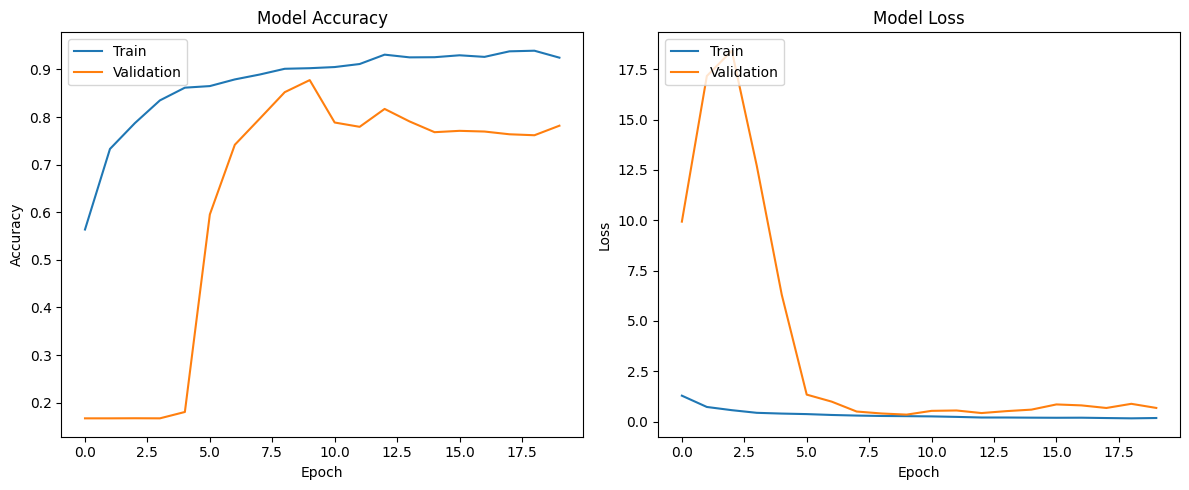

o:\uor\sem_6\ai\ecg-classification-project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Evaluating model on test data...
775/775 ━━━━━━━━━━━━━━━━━━━━ 338s 436ms/step - accuracy: 0.9749 - loss: 0.1112
Test Loss: 0.1790
Test Accuracy: 0.9500
775/775 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step

Classification Report:
              precision    recall  f1-score   support

           F       0.38      0.83      0.52       161
           M       0.99      1.00      0.99      2101
           N       1.00      0.98      0.99     18926
           Q       0.78      1.00      0.88      1608
           S       0.50      0.92      0.65       556
           V       0.96      0.52      0.67      1447

    accuracy                           0.95     24799
   macro avg       0.77      0.87      0.78     24799
weighted avg       0.97      0.95      0.95     24799



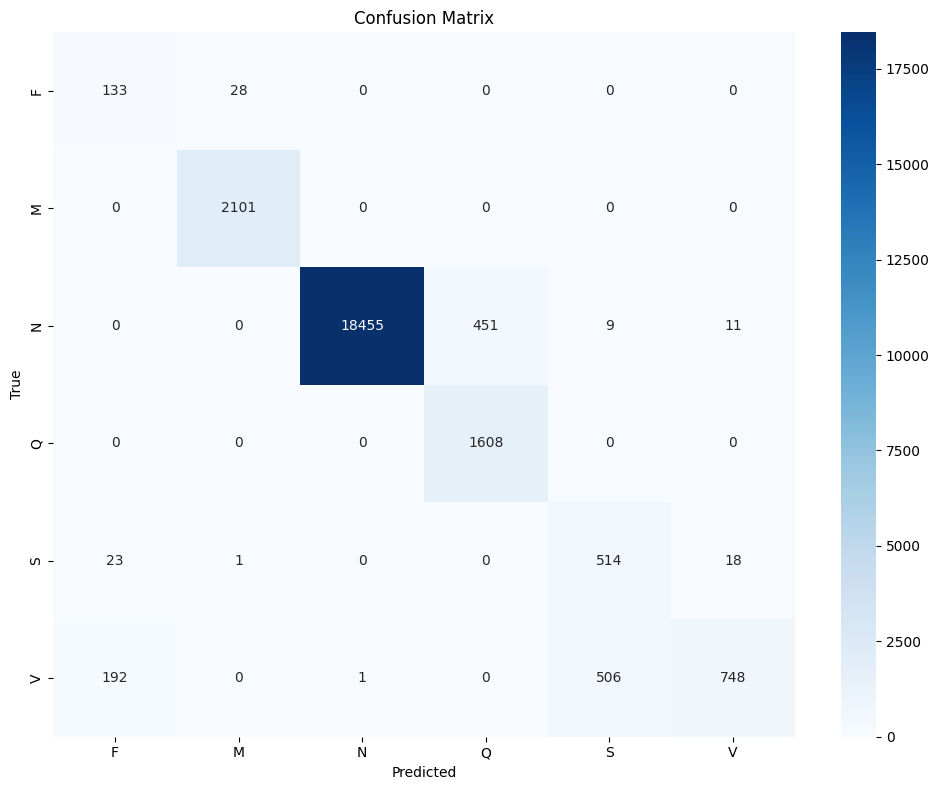

In [12]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('../data/training_history_balanced.png')
plt.show()

# Load the best model
best_model = load_model('../backend/model/ecg_model_balanced.h5')

# Evaluate on test data
print("Evaluating model on test data...")
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Generate classification report
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Save classification report to file
with open('../backend/model/classification_report_balanced.txt', 'w') as f:
    f.write(report)

# Generate confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('../data/confusion_matrix_balanced.png')
plt.show()


Per-Class Performance:
F:
  Precision: 0.3822
  Recall: 0.8261
  F1 Score: 0.5226
M:
  Precision: 0.9864
  Recall: 1.0000
  F1 Score: 0.9931
N:
  Precision: 0.9999
  Recall: 0.9751
  F1 Score: 0.9874
Q:
  Precision: 0.7810
  Recall: 1.0000
  F1 Score: 0.8770
S:
  Precision: 0.4995
  Recall: 0.9245
  F1 Score: 0.6486
V:
  Precision: 0.9627
  Recall: 0.5169
  F1 Score: 0.6727


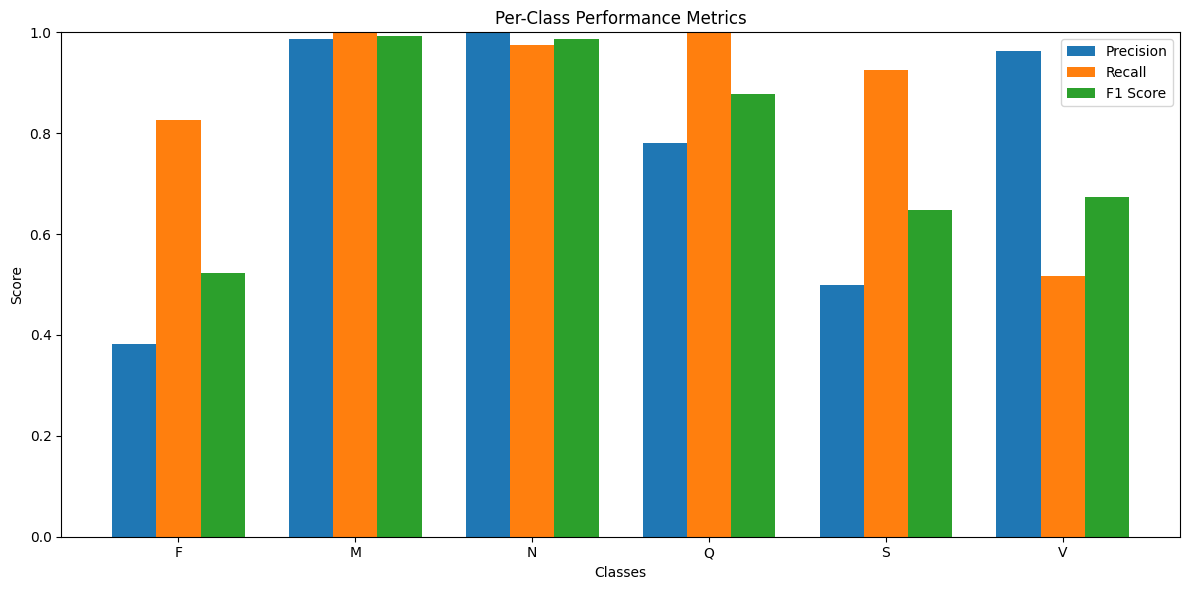


Top Misclassifications:

Class F is most confused with:
  - M: 28 samples (17.39%)

Class N is most confused with:
  - Q: 451 samples (2.38%)
  - V: 11 samples (0.06%)
  - S: 9 samples (0.05%)

Class S is most confused with:
  - F: 23 samples (4.14%)
  - V: 18 samples (3.24%)
  - M: 1 samples (0.18%)

Class V is most confused with:
  - S: 506 samples (34.97%)
  - F: 192 samples (13.27%)
  - N: 1 samples (0.07%)


In [13]:
# Analyze per-class performance
def analyze_class_performance(y_true, y_pred, class_names):
    """Analyze performance for each class"""
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate per-class metrics
    precision = np.zeros(len(class_names))
    recall = np.zeros(len(class_names))
    f1_score = np.zeros(len(class_names))
    
    for i in range(len(class_names)):
        # Precision: TP / (TP + FP)
        precision[i] = cm[i, i] / max(1, np.sum(cm[:, i]))
        # Recall: TP / (TP + FN)
        recall[i] = cm[i, i] / max(1, np.sum(cm[i, :]))
        # F1 Score: 2 * (precision * recall) / (precision + recall)
        f1_score[i] = 2 * precision[i] * recall[i] / max(1e-8, precision[i] + recall[i])
    
    # Print metrics
    print("\nPer-Class Performance:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1 Score: {f1_score[i]:.4f}")
    
    # Visualize per-class metrics
    plt.figure(figsize=(12, 6))
    
    # Plot precision, recall and f1-score for each class
    width = 0.25
    x = np.arange(len(class_names))
    
    plt.bar(x - width, precision, width, label='Precision')
    plt.bar(x, recall, width, label='Recall')
    plt.bar(x + width, f1_score, width, label='F1 Score')
    
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Per-Class Performance Metrics')
    plt.xticks(x, class_names)
    plt.legend()
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.savefig('../data/per_class_metrics.png')
    plt.show()
    
    # Analyze misclassifications
    print("\nTop Misclassifications:")
    for i, class_name in enumerate(class_names):
        if cm[i, i] < np.sum(cm[i, :]):
            # Find classes this class is most confused with
            incorrect_indices = np.argsort(cm[i, :])[::-1][1:4]  # Top 3 excluding itself
            print(f"\nClass {class_name} is most confused with:")
            for idx in incorrect_indices:
                if cm[i, idx] > 0:
                    percentage = (cm[i, idx] / np.sum(cm[i, :])) * 100
                    print(f"  - {class_names[idx]}: {cm[i, idx]} samples ({percentage:.2f}%)")

# Run the analysis
analyze_class_performance(y_true, y_pred, class_names)

In [15]:
# Save model summary
with open('../backend/model/model_summary_balanced.txt', 'w', encoding='utf-8') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Save class indices
import json
with open('../backend/model/class_indices_balanced.json', 'w', encoding='utf-8') as f:
    json.dump(balanced_generator.class_indices, f)

# Save training history
pd.DataFrame(history.history).to_csv('../backend/model/training_history_balanced.csv', encoding='utf-8')

# Save the final trained model
model.save('../backend/model/ecg_model_final_balanced.h5')
print("\nFinal model saved to '../backend/model/ecg_model_final_balanced.h5'")


Final model saved to '../backend/model/ecg_model_final_balanced.h5'


In [18]:
# Function for single image prediction
def predict_ecg_image(image_path, model, target_size=(128, 128), class_indices=None):
    """Make prediction on a single ECG image"""
    from tensorflow.keras.preprocessing import image
    
    # Load and preprocess image
    img = image.load_img(image_path, target_size=target_size, color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img_array)
    
    # Get top prediction
    predicted_class_idx = np.argmax(prediction, axis=1)[0]
    confidence = prediction[0][predicted_class_idx]
    
    # Get top 3 predictions
    top3_indices = np.argsort(prediction[0])[::-1][:3]
    top3_confidences = prediction[0][top3_indices]
    
    # Map indices to class names
    if class_indices is None:
        # Use test generator class indices if not provided
        class_indices = test_generator.class_indices
    
    class_names = {v: k for k, v in class_indices.items()}
    
    predicted_class = class_names[predicted_class_idx]
    top3_predictions = [(class_names[idx], conf) for idx, conf in zip(top3_indices, top3_confidences)]
    
    return predicted_class, confidence, top3_predictions

# Test the prediction function
def test_prediction(test_data_dir, model, class_indices):
    """Test prediction on a random image from test set"""
    import random
    
    # Get a random class
    classes = os.listdir(test_data_dir)
    random_class = random.choice(classes)
    class_dir = os.path.join(test_data_dir, random_class)
    
    # Get a random image
    images = os.listdir(class_dir)
    random_image = random.choice(images)
    image_path = os.path.join(class_dir, random_image)
    
    # Make prediction
    predicted_class, confidence, top3_predictions = predict_ecg_image(
        image_path, model, class_indices=class_indices
    )
    
    print("\nSample Prediction Test:")
    print(f"Image: {image_path}")
    print(f"True Class: {random_class}")
    print(f"Predicted Class: {predicted_class} with confidence: {confidence:.4f}")
    print("Top 3 Predictions:")
    for cls, conf in top3_predictions:
        print(f"  - {cls}: {conf:.4f}")

# Run a test prediction
test_prediction(test_data_dir, best_model, balanced_generator.class_indices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Sample Prediction Test:
Image: ../data/ECG_Image_data/test\Q\Q2579.png
True Class: Q
Predicted Class: Q with confidence: 1.0000
Top 3 Predictions:
  - Q: 1.0000
  - N: 0.0000
  - V: 0.0000


In [19]:
# ECG class descriptions
class_descriptions = {
    'F': 'Fusion of ventricular and normal beat',
    'M': 'Myocardial infarction',
    'N': 'Normal beat',
    'Q': 'Unclassifiable beat',
    'S': 'Supraventricular premature beat',
    'V': 'Premature ventricular contraction'
}

print("\nECG Class Descriptions:")
for class_name, description in class_descriptions.items():
    print(f"{class_name}: {description}")

# Generate final summary report
overall_accuracy = accuracy_score(y_true, y_pred)

print("\n======= ECG CLASSIFICATION MODEL SUMMARY =======")
print(f"Model trained with balanced approach for all ECG classes")
print(f"Original class distribution: {train_counts}")
print(f"Number of classes: {balanced_generator.num_classes}")
print(f"Final test accuracy: {overall_accuracy:.4f}")
print(f"Training epochs completed: {len(history.history['accuracy'])}")

print("\nClass descriptions:")
for class_name in balanced_generator.classes:
    if class_name in class_descriptions:
        print(f"  {class_name}: {class_descriptions[class_name]}")

print("\nModel files saved:")
print("  - Best model: '../backend/model/ecg_model_balanced.h5'")
print("  - Final model: '../backend/model/ecg_model_final_balanced.h5'")
print("  - Model summary: '../backend/model/model_summary_balanced.txt'")
print("  - Classification report: '../backend/model/classification_report_balanced.txt'")
print("  - Training history: '../backend/model/training_history_balanced.csv'")


ECG Class Descriptions:
F: Fusion of ventricular and normal beat
M: Myocardial infarction
N: Normal beat
Q: Unclassifiable beat
S: Supraventricular premature beat
V: Premature ventricular contraction

======= ECG CLASSIFICATION MODEL SUMMARY =======
Model trained with balanced approach for all ECG classes
Original class distribution: {'F': 642, 'M': 8405, 'N': 75709, 'Q': 6431, 'S': 2223, 'V': 5789}
Number of classes: 6
Final test accuracy: 0.9500
Training epochs completed: 20

Class descriptions:
  F: Fusion of ventricular and normal beat
  M: Myocardial infarction
  N: Normal beat
  Q: Unclassifiable beat
  S: Supraventricular premature beat
  V: Premature ventricular contraction

Model files saved:
  - Best model: '../backend/model/ecg_model_balanced.h5'
  - Final model: '../backend/model/ecg_model_final_balanced.h5'
  - Model summary: '../backend/model/model_summary_balanced.txt'
  - Classification report: '../backend/model/classification_report_balanced.txt'
  - Training history: